# Trabajo práctico integrador - Visión por Computadoras II
## Carrera de Especialización en Inteligencia Artificial - Cohorte 17
### Autores:
* Piñero, Juan Cruz 
* Lloveras, Alejandro
* Méndez, Diego Martín

**Objetivo del trabajo**

Utilizar modelos de *Computer Vision* para clasificar enfermedades de plantas (38 clases).

## Inicialización

In [130]:
# Importación de librerías
# Gestión de archivos y reporte
import os
import logging

# Manipulación y análisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Procesamiento de imágenes
from PIL import Image

# Machine Learning


In [148]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", DATASET_PATH)

Path to dataset files: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3


In [132]:
# Ruta de acceso al dataset
ROOT_DIR = f'{DATASET_PATH}/plantvillage dataset/color'

In [150]:
# Cargamos el dataframe desde el .CSV y definimos 'id' como índice
try:
    df = pd.read_csv('dataframe.csv').set_index('id')
except FileNotFoundError:
    print(f"Error: El archivo 'dataframe.csv' no se encontró en la ubicación actual: {os.getcwd()}")
    print("Se creará nuevamente al correr las celdas de 'Importación de imágenes'.")
    df = None
except Exception as e:
    print(f"Ocurrió un error al leer el archivo CSV: {e}")
    df = None

In [ ]:
# ELIMINACIÓN DEL DATASET DESCARGADO EN LOCAL
"""
import os, re, shutil

# Busca la carpeta raíz del dataset en el directorio donde fue descargado
match = re.search(r"^(.*?)/abdallahalidev/", DATASET_PATH)
if match:
    prefix = match.group(1)
    path_to_remove = os.path.join(prefix, "abdallahalidev/")
else:
    print('No se ha podido encontrar la carpeta "abdallahalidev" en ', DATASET_PATH)

# Valida la operación y elimina carpetas y subcarpetas
if os.path.exists(path_to_remove):
    respuesta = input(f"¿Estás seguro de que deseas eliminar la carpeta y todo su contenido? [Y/N] {path_to_remove} :").lower()
    if respuesta == 'y':
        try:
            shutil.rmtree(path_to_remove)
            print(f"Se eliminó correctamente la carpeta y su contenido: {path_to_remove}")
        except OSError as e:
            print(f"Error al eliminar la carpeta {path_to_remove}: {e}")
    else:
        print(f"Operación de eliminación cancelada por el usuario para: {path_to_remove}")
else:
    print(f"La carpeta no existe: {path_to_remove}")
"""

### Funciones necesarias

In [ ]:
# Carga de imagenes en memoria y visualización
def load_image(data: pd.DataFrame, index: int, root: str=ROOT_DIR):
    """
    Carga una imagen PIL desde una fila específica de un DataFrame.

    Args:
        dataframe (pandas.DataFrame): El DataFrame que contiene las rutas de las imágenes.
        index (int): El índice de la fila en el DataFrame para cargar la imagen.
        root_dir (str): El directorio raíz donde se encuentran las imágenes.

    Returns:
        PIL.Image.Image: La imagen cargada como un objeto PIL.Image, o None si ocurre un error.
    """
    if index < 0 or index >= len(data):
        print("Índice fuera de rango.")
        return None

    row = data.iloc[index]
    relative_path = row['image_path']
    filename = row['filename']
    full_path = os.path.join(root, relative_path, filename)

    try:
        img = Image.open(full_path)
        return img
    except FileNotFoundError:
        print(f"Archivo no encontrado: {full_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

# Dataset

El dataset es 'PlantVillage' , obtenido de Kaggle con más de 50 mil imágenes RGB de hojas de cultivos sanas y enfermas, categorizadas en 38 clases diferentes. La primera versión del dataset fue disponibilizada por David. P. Hughes, Marcel Salathe y utilizado para desarrollar el proyecto 'PlantVillage' de la universidad de Penn State.

[**Link al Paper original**](https://arxiv.org/abs/1511.08060)

## Contenido del dataset



Dentro del dataset encontramos una jerarquía de carpetas que contienen imagenes. 
En el primer nivel encontramos tres carpetas que describen el tipo de imagen segun su preprocesamiento. Estas son:

- **color**: imagenes en color
- **grayscale**: mismas imagenes pero en escala de grises. En principio es desconocido el algoritmo utilizado.
    - apriori podriamos decir que la escala de grises no es ideal para detectar anomalías en cultivos, ya que muchas enfermedades se manifiestan con una diferencia de color entre las partes afectadas y las partes no afectadas.   
- **segmented**: mismas imagenes pero despues de aplicar algún algoritmo de segmentación. En principio es desconocido el algoritmo utilizado.
    - Haciendo una inspección inicial podemos ver que no todas las segmentaciones son de buena calidad, por lo que apriori optaríamos por usar las imágenes en color, haciendo algun preprocesamiento de las mismas por nuestra cuenta si fuera necesario.


Dentro de cada una de las tres carpetas que describen el preoposesamiento (color,grayscale,segmented) encontramos 38 carpetas, cada una con sus respectivas imagenes. Los nombres de las carpetas indican tanto la especie como la enfermedad o bien la palabra 'healthy' como indicador de que la imagen es de una planta sana . Por ejemplo, la carpeta "Apple___Apple_scab" contiene imagenes de hojas de manzana con 'Sarna del manzano'.

Como se puede ver en la descripción disponible en kaggle, el número de imagenes dentro de cada clase varía entre 152 y 5507 segun la especie y la enfermedad.

En el análisis exploratorio obtenemos una tabla resumen con las especies y las enfermedades presentes en el dataset, así como la cardinalidad de cada conjunto.


### Tamaño de las imagenes
Las imágenes se encuentran normalizadas a un tamaño de 256x256 pixeles.

[**Link al Dataset**](https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset)

## Descripción del problema


El objetivo es construir un modelo que permita diagnosticar las enfermedades mediante una foto de una hoja de una planta. Por lo tanto podemos diagramarlo como un problema de clasificación. Donde las clases son las enfermedades, en conjunto con la especie de la planta. En otras palabras , las clases podrían ser los nombres de las carpetas que contienen las imagenes.

### Estado del arte

La aplicación de deep learning en este problema ha permitido grandes avances en los resultados obtenidos . Con los modelos del estado del arte se alcanzan resultados de mas de 95% de accuracy en clasificación y niveles de precisión de más del 90% en problemas de detección y segmentación de plagas y enfermedades en plantas / cultivos.

### Modelo a implementar como solución

La cantidad de imágenes en cada directorio nos permite predecir que , al intentar resolver la clasificación, tendremos un problema de desbalance de clases. Por lo tanto será importante tomar esto en cuenta a la hora de elegir la métrica a utilizar en el entrenamiento del modelo.

La exactitud del modelo así planteado estará lógicamente limitada a las especies y enfermedades tratadas. Se podría tambien plantear un modelo donde se intente clasificar entre 'enferma' o 'sana' para intentar generalizar a otras especies o enfermedades, aunque esa generalización sería también muy limitada dada la diversidad de especies que existen en el mundo real. Dicho problema en principio no lo contemplaremos en este trabajo. Sólo nos vamos a limitar a clasificar entre las 38 clases presentes en el dataset.

Una forma de incorporar al modelo más complejidad e intentar abarcar otras especies podría ser utilizando Transfer Learning con un modelo pre-entrenado. Fine-tuneandolo para éste dataset. O bien utilizando técnicas / arquitecturas de Few Shot Learning. 

### Etapa de preprocesamiento

El hecho de que el dataset ya cuente con directorios donde se facilitan los datos preprocesados, nos da un indicio de que esa etapa es muy importante para el problema que se quiere resolver.

Será necesaria una etapa de preprocesamiento donde podamos aplicar algúna transformación de las imagenes para mejorar su calidad y poder obtener un mejor resultado en el entrenamiento. Dichas transformaciones podrían consistir tanto en el resize como en transformaciones de espacio de color, segmentaciones, etc. 
A modo de referencia podemos mencionar un artículo que explora el estado del arte en el tema de detección de enfermedades en plantas con Computer Vision:

[_«Trends in Machine and Deep Learning Techniques for Plant Disease Identification: A Systematic Review»_](
https://www.researchgate.net/profile/Juvenal-Rodriguez/publication/386275339_Trends_in_Machine_and_Deep_Learning_Techniques_for_Plant_Disease_Identification_A_Systematic_Review/links/674b1535f309a268c0193cd3/Trends-in-Machine-and-Deep-Learning-Techniques-for-Plant-Disease-Identification-A-Systematic-Review.pdf)

Según este artículo se destacan los siguientes items clave en el preprocesamiento de las imagenes:
- Resizing y cropping. La arquitectura a utilizar puede llegar a requerir un tamaño determinado de la imagen de entrada.
- Normalización de las imagenes. Podria ser necesario llevar los valores de los pixeles a un rango normalizado [0,1]. Esto suele mitigar los efectos de variaciones en brillo y contraste.
- Reducción de ruido.
- Data augmentation: este proceso es clave cuando se cuenta con datasets de tamaño o dispoinibilidad limitada. Se pueden aplicar operaciones variadas a las imagenes para aumentar la cantidad de datos y mejorar la generalizabilidad del modelo. Incluso se podría aplicar una GAN para generar imagenes sinteticas.
- Transformaciones de espacio de color: podria ser a escala de grises, HSV, etc.


## Importación de imágenes

In [ ]:
# CONFIGURACIÓN INICIAL:
# Separador usado en los nombres de las subcarpetas
SEPARATOR = '___' # Separa entre 'group' y 'class'

# Extensiones de archivo de imagen a considerar (en minúsculas)
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

# Configuración básica de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
def process_image_directory(root_dir, separator='___', valid_extensions=None):
    """
    Recorre un directorio raíz, extrae rutas de imágenes y metadatos de subcarpetas.

    Args:
        root_dir (str): La ruta al directorio raíz que contiene las subcarpetas de clases.
        separator (str): El separador utilizado en los nombres de las subcarpetas
                         para dividir 'group' y 'class'.
        valid_extensions (set, optional): Un conjunto de extensiones de archivo (en minúsculas,
                                          incluyendo el punto) a considerar como imágenes.
                                          Si es None, se usará un conjunto predeterminado.

    Returns:
        pandas.DataFrame: Un DataFrame con las columnas 'image_path', 'filename', 'group', 'class'.
                          Retorna un DataFrame vacío si el directorio raíz no existe o
                          no se encuentran imágenes válidas.
    """
    if valid_extensions is None:
        valid_extensions = IMAGE_EXTENSIONS # Verifica que sean archivos de imagen

    data = []
    output_columns = ['image_path', 'filename', 'class', 'group', 'tag'] # Define la estructura para el Dataframe

    if not os.path.isdir(root_dir):
        logging.error(f"El directorio raíz especificado no existe: {root_dir}")
        return pd.DataFrame(data, columns=output_columns) # Asegura que exista el directorio

    logging.info(f"Comenzando el procesamiento del directorio: {root_dir}")

    # Exploración de cada sucarpeta
    for entry in os.scandir(root_dir):
        if entry.is_dir():
            subdir_name = entry.name
            subdir_path = entry.path
            logging.info(f"Procesando subdirectorio: {subdir_name}")

            if separator in subdir_name:
                try:
                    group_name, tag = subdir_name.split(separator, 1)
                except ValueError:
                    logging.warning(f"No se pudo dividir el nombre '{subdir_name}' usando '{separator}'. Saltando directorio.")
                    continue

                for sub_entry in os.scandir(subdir_path):
                    if sub_entry.is_file():
                        file_name = sub_entry.name
                        file_path = sub_entry.path

                        _, extension = os.path.splitext(file_name)
                        if extension.lower() in valid_extensions:
                            relative_path = os.path.relpath(os.path.dirname(file_path), root_dir) # Carpeta dónde encontrar a imagen
                            
                            # Almacena toda la información
                            data.append({
                                'image_path': f"{relative_path}/",
                                'filename': file_name,
                                'class': relative_path,
                                'group': group_name,
                                'tag': tag
                            })
                        else:
                            logging.debug(f"Archivo omitido (no es imagen válida): {file_path}")
            else:
                logging.warning(f"El nombre del subdirectorio '{subdir_name}' no contiene el separador '{separator}'. Saltando.")

    if not data:
        logging.warning("No se encontraron imágenes válidas en la estructura de directorios especificada.")

    # Construye el DataFrame
    df = pd.DataFrame(data, columns=output_columns)
    logging.info(f"Proceso completado. Se encontraron {len(df)} imágenes.")
    return df

In [ ]:
# Descomentar en caso de querer generarlo nuevamente el Dataframe
# del df

In [169]:
# Verificación de importación de Dataframe del CSV
build_df = False # inicializa el estado

try:
    if df is None:
        # No se ha podido importar el CSV
        build_df = True
    else:
        # El Dataframe ya ha sido cargado en memoria
        build_df = False
except NameError:
    # Cuando la variable 'df' aún no ha sido definida
    build_df = True

In [ ]:
if build_df:
    print("El Dataframe aún no ha sido creado, se procede a su construcción:")
    df = process_image_directory(ROOT_DIR)
else:
    print("El Dataframe ya ha sido importado, por lo que por eficiencia no se ejecutará nuevamente.\nEn caso de querer generarlo nuevamente descomentar las celdas anteriores y ejecutar nuevamente.")

2025-04-05 20:38:43,505 - INFO - Comenzando el procesamiento del directorio: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/color
2025-04-05 20:38:43,507 - INFO - Procesando subdirectorio: Strawberry___healthy
2025-04-05 20:38:43,526 - INFO - Procesando subdirectorio: Grape___Black_rot
2025-04-05 20:38:43,554 - INFO - Procesando subdirectorio: Potato___Early_blight
2025-04-05 20:38:43,572 - INFO - Procesando subdirectorio: Blueberry___healthy
2025-04-05 20:38:43,598 - INFO - Procesando subdirectorio: Corn_(maize)___healthy
2025-04-05 20:38:43,619 - INFO - Procesando subdirectorio: Tomato___Target_Spot
2025-04-05 20:38:43,648 - INFO - Procesando subdirectorio: Peach___healthy
2025-04-05 20:38:43,654 - INFO - Procesando subdirectorio: Potato___Late_blight
2025-04-05 20:38:43,690 - INFO - Procesando subdirectorio: Tomato___Late_blight
2025-04-05 20:38:43,737 - INFO - Procesando subdirectorio: Tomato___Tomato_mosaic_vi

In [63]:
df.sample(5)

,image_path,filename,class,group,tag
32676,Tomato___Tomato_Yellow_Leaf_Curl_Virus/,1cd0ab0b-f4cf-4f2f-960a-455de4cd4c1e___YLCV_GC...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato,Tomato_Yellow_Leaf_Curl_Virus
46177,Apple___Black_rot/,50755673-3ea3-4e06-acbb-703413571a91___JR_FrgE...,Apple___Black_rot,Apple,Black_rot
11065,"Pepper,_bell___healthy/",a8d0f75a-6f10-44db-b6c4-72f19646167d___JR_HL 5...,"Pepper,_bell___healthy","Pepper,_bell",healthy
28529,Tomato___healthy/,8f009cfa-d6f0-4e8b-8950-71638f04d2c1___RS_HL 0...,Tomato___healthy,Tomato,healthy
44581,Squash___Powdery_mildew/,f7ed022b-2f5a-475d-ad90-bb6d162bbe3f___MD_Powd...,Squash___Powdery_mildew,Squash,Powdery_mildew


In [84]:
# Mueve el índice a una columna 'id' para poder tener un control de los datos durante el proceso de ETL
df = df.reset_index(names='id')

# Define la columna 'id' como index
df = df.set_index('id')

df.sample(5)

,image_path,filename,class,group,tag
id,,,,,
11480,"Pepper,_bell___healthy/",c0466e8b-d9cd-4bad-83c0-e8813b17788c___JR_HL 8...,"Pepper,_bell___healthy","Pepper,_bell",healthy
50958,Soybean___healthy/,d6b09d1b-49c8-46b8-b3c0-1c07d0b8e01f___RS_HL 3...,Soybean___healthy,Soybean,healthy
14769,Orange___Haunglongbing_(Citrus_greening)/,331ade5c-7616-4b52-97a2-39908eb8ee29___CREC_HL...,Orange___Haunglongbing_(Citrus_greening),Orange,Haunglongbing_(Citrus_greening)
25345,Corn_(maize)___Common_rust_/,RS_Rust 1815.JPG,Corn_(maize)___Common_rust_,Corn_(maize),Common_rust_
30342,Tomato___Tomato_Yellow_Leaf_Curl_Virus/,b31c5bf6-8fbe-4346-a2d4-c4eb1c3a2435___YLCV_NR...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato,Tomato_Yellow_Leaf_Curl_Virus


In [85]:
# Guardamos el dataframe como .CSV para evitar realizar este proceso nuevamente
df.to_csv('dataframe.csv')

# Análisis exploratorio (EDA)

## Información general

In [ ]:
# Verificamos la importación
df.sample(5)

,image_path,filename,class,group,tag
id,,,,,
16299,Orange___Haunglongbing_(Citrus_greening)/,c3761f85-eb13-446a-a673-19993d0a73dc___CREC_HL...,Orange___Haunglongbing_(Citrus_greening),Orange,Haunglongbing_(Citrus_greening)
6777,Peach___healthy/,04c14871-257f-4067-80f7-ecc5e50f42a4___Rutg._H...,Peach___healthy,Peach,healthy
6449,Tomato___Target_Spot/,01e0b8b1-e713-4c6d-973b-f7636280c58a___Com.G_T...,Tomato___Target_Spot,Tomato,Target_Spot
40489,Peach___Bacterial_spot/,82d203aa-eb50-4e38-b64b-0976fbcfb474___Rut._Ba...,Peach___Bacterial_spot,Peach,Bacterial_spot
12297,Orange___Haunglongbing_(Citrus_greening)/,2063fc79-fd1b-4669-8f0b-aeefb1a433cb___UF.Citr...,Orange___Haunglongbing_(Citrus_greening),Orange,Haunglongbing_(Citrus_greening)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54305 entries, 0 to 54304
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  54305 non-null  object
 1   filename    54305 non-null  object
 2   class       54305 non-null  object
 3   group       54305 non-null  object
 4   tag         54305 non-null  object
dtypes: object(5)
memory usage: 2.5+ MB


Verificamos que no hay valores nulos en las tiquetas, carpetas vacías, ni errores en el procesamiento del dataset.

In [ ]:
df.describe()

,image_path,filename,class,group,tag
count,54305,54305,54305,54305,54305
unique,38,54305,38,14,21
top,Orange___Haunglongbing_(Citrus_greening)/,c7f4b7b2-b13c-476e-a936-c91ce39749a3___RS_HL 6...,Orange___Haunglongbing_(Citrus_greening),Tomato,healthy
freq,5507,1,5507,18160,15084


## Visualización de imágenes

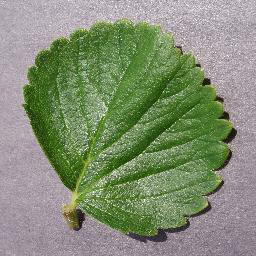

In [ ]:
# Permite visualizar una imagen específica (con iloc)
id = 0 # Indice de la imagen a cargar
image = load_image(data=df, index=id, root=ROOT_DIR)

#image.show() #popup option
image

Visualizando 10 imágenes aleatorias:
Imagen #1 (Índice: 8175):


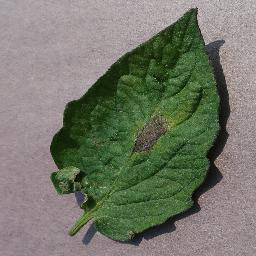

Imagen #2 (Índice: 30250):


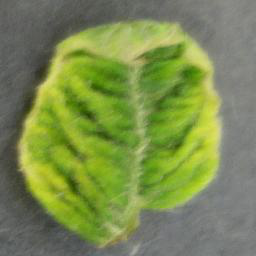

Imagen #3 (Índice: 34717):


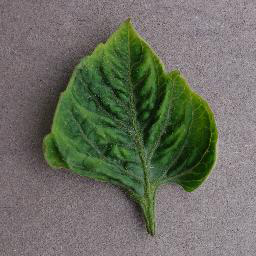

Imagen #4 (Índice: 53190):


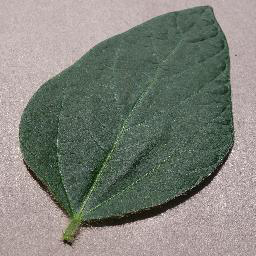

Imagen #5 (Índice: 16643):


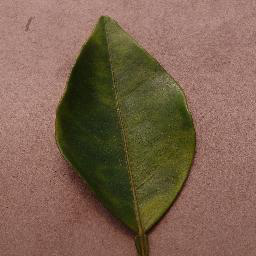

Imagen #6 (Índice: 17083):


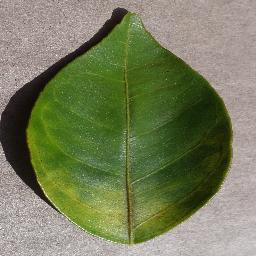

Imagen #7 (Índice: 12353):


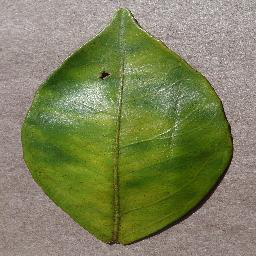

Imagen #8 (Índice: 43987):


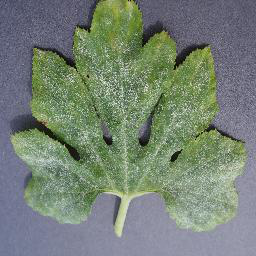

Imagen #9 (Índice: 28151):


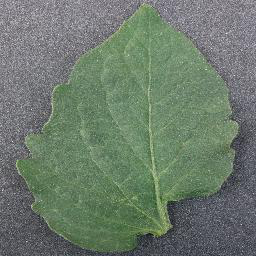

Imagen #10 (Índice: 45299):


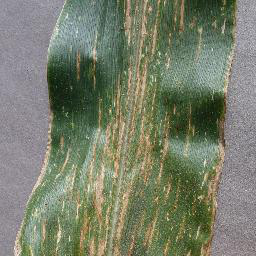

In [ ]:
import random

# Obtener 10 índices aleatorios del DataFrame
num_to_display = 10
random_indices = random.sample(range(len(df)), num_to_display)

print(f"Visualizando {num_to_display} imágenes aleatorias:")
for i, index in enumerate(random_indices):
    try:
        image = load_image(data=df, index=index, root=ROOT_DIR)
        print(f"Imagen #{i+1} (Índice: {index}):")
        display(image) # Muestra la imagen directamente en entornos como Jupyter Notebook
    except FileNotFoundError:
        print(f"Error: No se encontró la imagen en la ruta: {os.path.join(ROOT_DIR, df.loc[index, 'relative_path'])}")
    except Exception as e:
        print(f"Error al cargar la imagen en el índice {index}: {e}")

## Tamaño de las imágenes

In [ ]:
sizes = []
for index in range (0,df.shape[0]):
    
    image = load_image(data=df, index=index, root=ROOT_DIR)
    sizes.append(image.size)

In [ ]:
set(sizes)

{(256, 256)}

## Distribución entre clases

In [102]:
print("Conteo por grupo:")
print(df['group'].value_counts())

Conteo por grupo:
group
Tomato                     18160
Orange                      5507
Soybean                     5090
Grape                       4062
Corn_(maize)                3852
Apple                       3171
Peach                       2657
Pepper,_bell                2475
Potato                      2152
Cherry_(including_sour)     1906
Squash                      1835
Strawberry                  1565
Blueberry                   1502
Raspberry                    371
Name: count, dtype: int64


In [103]:
print("Conteo por etiqueta:")
print(df['tag'].value_counts())

Conteo por etiqueta:
tag
healthy                                15084
Haunglongbing_(Citrus_greening)         5507
Bacterial_spot                          5421
Tomato_Yellow_Leaf_Curl_Virus           5357
Late_blight                             2909
                                       ...  
Leaf_Mold                                952
Apple_scab                               630
Cercospora_leaf_spot Gray_leaf_spot      513
Tomato_mosaic_virus                      373
Cedar_apple_rust                         275
Name: count, Length: 21, dtype: int64


In [104]:
df[df['group'] == 'Raspberry']['tag'].value_counts()

tag
healthy    371
Name: count, dtype: int64

Como puede verse, todos los datos pertenecientes al grupo `Raspberry` tienen la etiqueta `helathy`.

Esto indica que no se cuenta con datos de enfermedades para esta clase.

## Dataset split

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(df,
               target_column='class',
               test_size=0.20,
               validation_size=0.0, # Por defecto no define un conjunto de validación
               random_state=42,     # Semilla para reproducibilidad
               split_column_name='split'):
    """
    Añade una columna al DataFrame indicando la división (train/test/validation).

    Realiza una división estratificada para mantener el balance de clases.

    Args:
        df (pd.DataFrame): DataFrame de entrada con al menos la columna 'target_column'.
        target_column (str): Nombre de la columna que contiene las etiquetas de clase
                             para la estratificación (ej: 'class').
        test_size (float): Proporción del dataset a incluir en el conjunto de test (ej: 0.20).
        validation_size (float): Proporción del dataset a incluir en el conjunto de validación.
                                 La proporción de entrenamiento será 1.0 - test_size - validation_size.
                                 Si es 0.0, solo se crearán conjuntos de train y test.
        random_state (int): Semilla para el generador de números aleatorios para asegurar
                            divisiones reproducibles.
        split_column_name (str): Nombre de la nueva columna que contendrá las etiquetas
                                 'train', 'test' o 'validation'.

    Returns:
        pd.DataFrame: El DataFrame original con la nueva columna 'split_column_name'.

    Raises:
        ValueError: Si test_size + validation_size >= 1.0, o si target_column no existe.
        ImportError: Si scikit-learn no está instalado.
    """
    if target_column not in df.columns:
        raise ValueError(f"La columna objetivo '{target_column}' no se encuentra en el DataFrame.")

    if not isinstance(test_size, float) or not (0.0 <= test_size < 1.0):
         raise ValueError("test_size debe ser un float entre 0.0 y 1.0.")

    if not isinstance(validation_size, float) or not (0.0 <= validation_size < 1.0):
         raise ValueError("validation_size debe ser un float entre 0.0 y 1.0.")

    if test_size + validation_size >= 1.0:
        raise ValueError("La suma de test_size y validation_size debe ser menor que 1.0.")

    # Crear la nueva columna inicializada (opcional, pero ayuda a la claridad)
    df[split_column_name] = 'unassigned'

    # Extraer etiquetas para estratificación
    labels = df[target_column]
    indices = df.index # Usaremos los índices para la división

    # --- Lógica de División ---

    # Caso 1: División en Train / Test (sin Validación)
    if validation_size == 0.0:
        train_indices, test_indices = train_test_split(
            indices,
            test_size=test_size,
            random_state=random_state,
            stratify=labels # Permite mantener el balance de clases
        )
        df.loc[train_indices, split_column_name] = 'train'
        df.loc[test_indices, split_column_name] = 'test'
        logging.info(f"División completada: Train ({1-test_size:.1%}), Test ({test_size:.1%}). Estratificada por '{target_column}'.")

    # Caso 2: División en Train / Test / Validation
    else:
        # Paso 1: Dividir en (Train + Validation) y Test
        remaining_indices, test_indices = train_test_split(
            indices,
            test_size=test_size, # Tamaño final del conjunto de test
            random_state=random_state,
            stratify=labels
        )

        # Calcular el tamaño relativo de validación respecto al conjunto restante (Train + Validation)
        # Ejemplo: test=0.2, val=0.1 -> Total 0.3. Restante 0.7. val_rel = 0.1 / 0.7 = 0.142...
        # train_test_split tomará el 14.2% del 70% restante, lo que equivale al 10% del total original.
        relative_val_size = validation_size / (1.0 - test_size)

        # Obtener las etiquetas correspondientes SOLO al conjunto restante para la segunda estratificación
        remaining_labels = df.loc[remaining_indices, target_column]

        # Paso 2: Dividir el conjunto restante en Train y Validation
        train_indices, validation_indices = train_test_split(
            remaining_indices, # Dividir solo los índices restantes
            test_size=relative_val_size, # Tamaño relativo calculado
            random_state=random_state,   # Usar la misma semilla para consistencia
            stratify=remaining_labels    # Estratificar usando las etiquetas restantes
        )

        # Asignar etiquetas de división al DataFrame original
        df.loc[train_indices, split_column_name] = 'train'
        df.loc[validation_indices, split_column_name] = 'valid'
        df.loc[test_indices, split_column_name] = 'test'

        train_actual_prop = len(train_indices) / len(df)
        val_actual_prop = len(validation_indices) / len(df)
        test_actual_prop = len(test_indices) / len(df)
        logging.info(f"División completada: Train ({train_actual_prop:.1%}), Validation ({val_actual_prop:.1%}), Test ({test_actual_prop:.1%}). Estratificada por '{target_column}'.")

    return df

In [112]:
# Disivión del dataset
# (Ejemplo: 80% train, 20% test)
try:
        df_split = split_data(df.copy(), # Usar .copy() para no modificar el original directamente aquí
                                target_column='class',
                                test_size=0.2,
                                random_state=42) # Usa la semilla que prefieras

except ValueError as e:
        print(f"\nError al dividir los datos: {e}")
except ImportError:
        print("\nError: La biblioteca scikit-learn no está instalada. Por favor, instálala con 'pip install scikit-learn'")
except Exception as e:
        print(f"\nOcurrió un error inesperado: {e}")


2025-04-05 20:59:03,551 - INFO - División completada: Train (80.0%), Test (20.0%). Estratificada por 'class'.


In [113]:
df_split.sample(5)

,image_path,filename,class,group,tag,split
id,,,,,,
12418,Orange___Haunglongbing_(Citrus_greening)/,885a6772-0c95-4805-bc03-fe7a5b07c073___CREC_HL...,Orange___Haunglongbing_(Citrus_greening),Orange,Haunglongbing_(Citrus_greening),train
3707,Blueberry___healthy/,40f80efb-32a6-4805-9c01-ada369c6900b___RS_HL 5...,Blueberry___healthy,Blueberry,healthy,test
36742,Tomato___Spider_mites Two-spotted_spider_mite/,6eb5d1ea-faf3-4a41-8419-89158aef70a5___Com.G_S...,Tomato___Spider_mites Two-spotted_spider_mite,Tomato,Spider_mites Two-spotted_spider_mite,train
19954,Cherry_(including_sour)___Powdery_mildew/,5cdf0423-83a1-42ec-97f0-4c91a6130cb4___FREC_Pw...,Cherry_(including_sour)___Powdery_mildew,Cherry_(including_sour),Powdery_mildew,train
49302,Soybean___healthy/,d5006066-4ff3-4264-860d-0773a2418039___RS_HL 3...,Soybean___healthy,Soybean,healthy,test


In [114]:
df_split['split'].value_counts()

split
train    43444
test     10861
Name: count, dtype: int64

In [115]:
# Guardamos el dataframe como .CSV para evitar realizar este proceso nuevamente
df_split.to_csv('dataframe_splitted.csv')

In [116]:
print("\n--- Conteo de muestras por 'split' ---")
print(df_split['split'].value_counts(normalize=True)) # normalize=True muestra proporciones

print("\n--- Verificación del Balance de Clases por 'split' ---")

# Comprobar si las proporciones de clases son similares en cada split
print(df_split.groupby('split')['class'].value_counts(normalize=True))


--- Conteo de muestras por 'split' ---
split
train    0.8
test     0.2
Name: proportion, dtype: float64

--- Verificación del Balance de Clases por 'split' ---
split  class                                   
test   Orange___Haunglongbing_(Citrus_greening)    0.101464
       Tomato___Tomato_Yellow_Leaf_Curl_Virus      0.098610
       Soybean___healthy                           0.093730
       Peach___Bacterial_spot                      0.042353
       Tomato___Bacterial_spot                     0.039131
                                                     ...   
train  Tomato___Tomato_mosaic_virus                0.006859
       Raspberry___healthy                         0.006836
       Peach___healthy                             0.006629
       Apple___Cedar_apple_rust                    0.005064
       Potato___healthy                            0.002808
Name: proportion, Length: 76, dtype: float64
